# 2. zárthelyi dolgozat, A) változat (2024. 05. 23.)

**A második zárthelyi dolgozat során egy mély konvolúciós neuronhálót (CNN) tanítunk be egy bináris klasszifikációs feladatra a PyTorch könyvtár segítségével: kutyákat és macskákat ábrázoló képek megkülönböztetését tanuljuk meg. A neuronhálónk alapját egy, az ImageNet adatbázison előtanított mélyháló (a MobileNet 2) adja, melynek architektúráját kisebb átalakításokkal alkalmassá tesszük a feladatunk megoldására, majd finomhangoljuk azt. Mivel nem áll rendelkezésünkre sok címkézett kép háziállatokról, ezért adat-augmentációt is fogunk használni a betanításhoz.**

A zárthelyi több részfeladatból áll (A - H), melyek egymásra épülnek. A feladat automatikus tesztelőszkripttel rendelkezik és vizsgálja az egyes részfeladatokra adott megoldások helyességét. Éppen ezért, **ne változtasd meg a notebook struktúráját**, ne szedd több részre, illetve ne módosítsd a megírt részeket, csak a megoldásaidat írd be a megfelelő helyre, különben nem fogjuk tudni értékelni! A megoldások az `# Implement your solution BELOW` és `# Implement your solution ABOVE` sorok közé írandók. Ha a megoldott részfeladatok futtatásakor a "Tester: .... OK" felirat megjelenik, a tesztelőszkript nem talált hibát a megoldásban, azonban, a tesztelő nem teljeskörű, nem vesz észre mindenfajta hibát.

**A feladatban elérhető klasszifikációs pontosság:** Körülbelül 80-90% közti (bináris) accuracy érhető el a teszthalmazon a feladat helyes megoldásával.

**A megoldott feladatsor beadása:** A kész megoldást tartalmazó notebookot (.ipynb) fájlként kell feltölteni a Canvas-ban, a "2. zárthelyi dolgozat" beadási felületén.
**Kérjük a notebook szerkezetét nem módosítani és nem szétszedni külön feladatok szerint!**

**Rendelkezésre álló idő:** 100 perc

**Értékelés:** Legfeljebb 40 pont gyűjthető: lásd a részfeladatokra adható pontokat az egyes feladatoknál. Minimum 20 pontot el kell érni ezen a zárthelyin a tárgy teljesítéséhez - ha ez nem sikerül, javító ZH megírása lesz szükséges.

**Kikötés:** Ahol csak lehet, hatékony, vektorizált megoldásokat várunk. Nagy számú iterációt (50+) végrehajtó ciklus és hasonló, nem hatékony konstrukció a kódban pontlevonást eredményezhet. Sok ezer pixel feletti iteráció még inkább kerülendő! Kivételek, ahol büntetés nélkül használható hosszabb ciklus:
- A háló betanításánál a tanítási/validációs/teszt loopban, akár epoch-ok, akár batch-ek iterálására.
- A háló paramétereinek felsorolására.



---

Tesztelő szkript letöltése, importok.

In [3]:
import os
import tarfile
import PIL
from PIL import Image
import io
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from annbsc24_p1_zh2a_tester import Tester
tester = Tester()

Az adatbázis beolvasása.

In [4]:
jpg_ims = []
label_ims = []

# unpacking tar content directly into memory and decoding jpg/png images from there to avoid working with many small files on disk
with tarfile.open("annbsc24_p1_hw2_data.tar", "r") as tar:
    tar_members = tar.getmembers()
    tar_jpg_members = [member for member in tar_members if member.name[-4:] == '.jpg']  # list only jpg images, not label images
    for jpg_member in tar_jpg_members:
        filename_noext = os.path.split(jpg_member.name)[-1][:-4]

        # get next jpg image
        file_in_tar = tar.extractfile(jpg_member)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        jpg_ims.append(npy_image)

        # get label image corresponding to the jpg image
        label_member_name = 'PascalVOC_annbsc_data/SegmentationClass/' + filename_noext + '.png'
        file_in_tar = tar.extractfile(label_member_name)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))  # using PIL instead of cv2 as it supports loading palette coded png images as single channel integer arrays
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        label_ims.append(npy_image)

jpg_ims = np.stack(jpg_ims, axis=0)
label_ims = np.stack(label_ims, axis=0)

# removing 'border region' (255) from label images and replacing it with background (0)
label_ims[label_ims == 255] = 0

print("Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes:", jpg_ims.shape, label_ims.shape)


Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes: (2913, 240, 320, 3) (2913, 240, 320)


**Adatbázis:** A feladat során a Pascal VOC adatbázis egy csökkentett felbontású részhalmazával kell dolgozni. Az adatbázisban húsz kategóriába (plusz "háttér") sorolt objektumokról készült képek vannak. A színes képekhez azonos felbontású szegmentációs címke tartozik, mely minden pixelre meghatározza annak szemantikus kategóriáját.

Az `(n_images, size_y=240, size_x=320, n_channels=3)` alakú, `np.uint8` adattípusú `jpg_ims` tömb tartalamazza a különböző állatokról, emberekről, járművekről és egyéb tárgyakról készült képeket. A `label_ims` tömb az említett képekhez rendelt szegmentációs címkéket tárolja. Ennek alakja `(n_images, size_y=240, size_x=320)`, adattípusa ugyancsak `np.uint8`. Az egy-egy képhez tartozó szegmentációs címke, a színes képekkel megegyező felbontású egycsatornás kép, mely minden egyes pixelre megadja az ahhoz rendelt szemantikus kategóriát egy integer formájában. Az adatbázis húsz fajta objektumot (élőlényt/tárgyat) különböztet meg, ezek 1 és 20 közti egész számokkal vannak reprezentálva. Azok a pixelek, melyek egyik kiemelt objektumtípushoz sem tartoznak, a "háttér" (background) kategóriába soroltak és 0 értéket kapnak a szegmentációs címkén.

Elsőként belenézünk a letöltött adatbázis tartalmába és kirajzolunk néhány képet a hozzájuk tartozó szegmentációs címkékkel együtt.

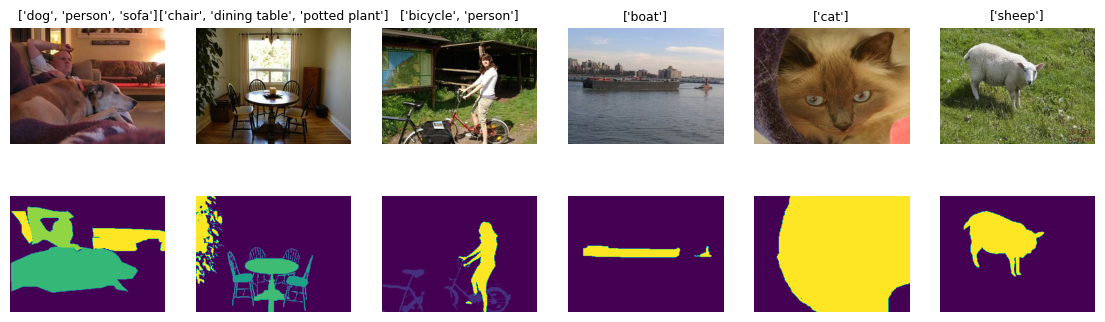

In [5]:
ORIG_CAT_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

sample_idxs = np.random.choice(jpg_ims.shape[0], size=6)
sample_jpg_ims = jpg_ims[sample_idxs,:,:,:]
sample_label_ims = label_ims[sample_idxs,:,:]

fig, axs = plt.subplots(2, 6)
fig.set_figheight(4)
fig.set_figwidth(14)
for plot_idx in range(6):
    axs[0, plot_idx].imshow(sample_jpg_ims[plot_idx])
    axs[1, plot_idx].imshow(sample_label_ims[plot_idx])
    axs[0, plot_idx].axis('off')
    axs[1, plot_idx].axis('off')
    u_labs = np.unique(sample_label_ims[plot_idx,:,:])
    text = str([ORIG_CAT_NAMES[lab] for lab in u_labs if lab > 0])
    axs[0, plot_idx].set_title(text, fontsize=9)


### **A**: A bináris klasszifikációhoz releváns képek kiválogatása - 3 + 2 + 3 pont

Ebben a feladatban kiválasztjuk azoknak a képeknek az indexeit, melyek a kutya-macska klasszifikációs feladat szempontjából relevánsak.

Készítsd el a `cats_im_idxs` és `dogs_im_idxs` egydimenziós tömböket, melyek a tanításhoz és kiértékeléshez felhasználandó macskás, illetve kutyás képek indexeit fogják tárolni! Az indexek a `jpg_ims` és `label_ims` tömböket indexelik.

#### **Alapfeladat** - 3 pont

A `cats_im_idxs` tömbbe kerüljön be azoknak a képeknek az indexe a `jpg_ims` és `label_ims` tömbökből, melyek macskákat tartalmaznak, de kutyát nem! Ehhez hasonlóan, a `dogs_im_idxs` tömbbe azok az indexek kerüljenek, melyekhez olyan kutyákat tartalmazó képek tartoznak, amiken nincs macska! A macskák és kutyák jelenlétét a `label_ims` tömbben az adott képen jelen levő 8-as és 12-es értékű pixelek jelzik (macska: 8, kutya: 12). Akár egyetlen pixelnyi macska vagy kutya is számít!

#### **Extra feladat \#1** - 2 pont

Az alapfeladat feltételeinek teljesülése mellett, a `cats_im_idxs` és `dogs_im_idxs` tömbökbe csak olyan képek indexei kerüljenek be, melyeken legalább 1000 pixelnyi macska, vagy kutya jelen van! Azt, hogy ezek a pixelek összefüggő területet alkotnak-e, nem kell vizsgálni.

#### **Extra feladat \#2** - 3 pont

Az alapfeladat feltételeinek teljesülése mellett, a `cats_im_idxs` és `dogs_im_idxs` tömbökbe csak olyan képek indexei kerüljenek be, melyeken a macska, vagy kutya tartalmú pixelek száma nagyobb, mint bármilyen másik előtér (nem háttér) kategóriába eső pixelek száma (kategóriánként egyedileg)! A háttér kategóriát a `label_ims` tömbben a 0 értékű pixelek, az előtér kategóriákat pedig az 1, ..., 20 értékű pixelek kódolják.

_Például a 2500 darab "háttér" pixelt, 1300 darab "macska" pixelt, 1000 darab "hajó" pixelt és 800 darab "ló" pixelt tartalmazó kép indexe bekerülhet a `cats_im_idxs` tömbbe._

In [112]:
CATS_ORIG_IDX = 8
DOGS_ORIG_IDX = 12

# implement your solution BELOW

def get_relevant_indices(label_ims, min_pixels=None):
    total_images = label_ims.shape[0]
    all_indices = np.arange(total_images)
    cats_im_idxs = []
    dogs_im_idxs = []

    for idx, img in enumerate(label_ims):
        cat_pixels = np.count_nonzero(img == CATS_ORIG_IDX)
        dog_pixels = np.count_nonzero(img == DOGS_ORIG_IDX)

        # Alap:
        if cat_pixels == 0 and dog_pixels > 0:
            dogs_im_idxs.append(idx)
        elif cat_pixels > 0 and dog_pixels == 0:
            cats_im_idxs.append(idx)

        # Extra feladat #1: 
        if min_pixels is not None:
            if cat_pixels >= min_pixels and dog_pixels == 0:
                cats_im_idxs.append(idx)
            elif dog_pixels >= min_pixels and cat_pixels == 0:
                dogs_im_idxs.append(idx)

    cats_im_idxs = np.array(cats_im_idxs)
    dogs_im_idxs = np.array(dogs_im_idxs)
    return cats_im_idxs, dogs_im_idxs

# Alap
cats_im_idxs, dogs_im_idxs = get_relevant_indices(label_ims)

# Extra feladat #1
cats_im_idxs_min_pixels, dogs_im_idxs_min_pixels = get_relevant_indices(label_ims, min_pixels=1000)

# implement your solution ABOVE

tester.test('A', cats_im_idxs, dogs_im_idxs)

Tester: Task A - Alapfeladat OK, Extra feladat #1 & #2 missing.


### **B**: Felbontás tanító-, validációs- és teszthalmazra - 2 pont

- Bontsuk fel tanító-, validációs- és teszthalmazra a két, indexeket tartalmazó tömböt! Használjunk 50%/25%/25%-os felosztást! Állítsuk elő így a `cats_im_idxs_train`, `cats_im_idxs_val`, `cats_im_idxs_test` és `dogs_im_idxs_train`, `dogs_im_idxs_val`, `dogs_im_idxs_test` címkéket tartalmazó tömböket!

In [114]:
# implement your solution BELOW
import numpy as np
import math

dataset_len_cat = cats_im_idxs.shape[0]
dataset_len_dog = dogs_im_idxs.shape[0]

sort_idx_cat = np.arange(dataset_len_cat)
sort_idx_dog = np.arange(dataset_len_dog)

train_end_cat = math.floor(dataset_len_cat * 0.5)
val_end_cat = train_end_cat + math.floor(dataset_len_cat * 0.25)
test_end_cat = dataset_len_cat

train_end_dog = math.floor(dataset_len_dog * 0.5)
val_end_dog = train_end_dog + math.floor(dataset_len_dog * 0.25)
test_end_dog = dataset_len_dog

train_slice_cat = sort_idx_cat[0:train_end_cat]
val_slice_cat = sort_idx_cat[train_end_cat:val_end_cat]
test_slice_cat = sort_idx_cat[val_end_cat:test_end_cat]

train_slice_dog = sort_idx_dog[0:train_end_dog]
val_slice_dog = sort_idx_dog[train_end_dog:val_end_dog]
test_slice_dog = sort_idx_dog[val_end_dog:test_end_dog]

cats_im_idxs_train = cats_im_idxs[train_slice_cat]
dogs_im_idxs_train = dogs_im_idxs[train_slice_dog]
cats_im_idxs_val = cats_im_idxs[val_slice_cat]
dogs_im_idxs_val = dogs_im_idxs[val_slice_dog]
cats_im_idxs_test = cats_im_idxs[test_slice_cat]
dogs_im_idxs_test = dogs_im_idxs[test_slice_dog]

# implement your solution ABOVE

print("Training set shapes (cats, dogs):", cats_im_idxs_train.shape, dogs_im_idxs_train.shape)
print("Validation set shapes (cats, dogs):", cats_im_idxs_val.shape, dogs_im_idxs_val.shape)
print("Test set shapes (cats, dogs):", cats_im_idxs_test.shape, dogs_im_idxs_test.shape)

tester.test('B', cats_im_idxs_train, cats_im_idxs_val, cats_im_idxs_test, dogs_im_idxs_train, dogs_im_idxs_val, dogs_im_idxs_test)



Training set shapes (cats, dogs): (121,) (121,)
Validation set shapes (cats, dogs): (60,) (60,)
Test set shapes (cats, dogs): (62,) (61,)
Tester: Dataset split (Task B) OK


### **C**: Az adat-iterátorok létrehozása a bináris klasszifikációs feladathoz, adat-augmentáció - 7 pont

A házi feladatokhoz és az előző zárthelyihez hasonlóan, ezúttal is iterátorokkal oldjuk meg a neuronhálónk betanítását. Ebben a részfeladatban **elő kell állítanod három iterátor objektumot** `dataloader_train`, `dataloader_val` és `dataloader_test` néven, melyek az előző részfeladatban elkészített megfelelő részhalmazhoz tartozó kutya-macska indextömb párok alapján sorolják fel a képeket és a hozzájuk tartozó klasszifikációs címkéket!

Például, a `dataloader_train` iterátor a `cats_im_idxs_train` és `dogs_im_idxs_train` tömbök felhasználásával felsorolja az összes általuk indexelt képet és bináris klasszifikációs címkét generál hozzájuk. Hasonlóan, a validációs és a teszt iterátor a további két pár index tömbbel dolgozik.

**Az iterátorok minden lépésben két tenzort adnak vissza**, melyek egy-egy kötegnyi input képet és az azokhoz tartozó bináris klasszifikációs címkéket tartalmaznak.

A képek esetén szükséges lesz a tengelyek sorrendjének átrendezése, mivel a csatornákat felsoroló tengely eddig hátul volt (_channel-last_ formátum), de a PyTorch erre a tengelyre közvetlenül a kötegméret tengely után számít (_channel-first_ formátum). Ebből kifolyólag, a visszaadott tenzorok alakja `(batch_size, 3, 240, 320)` és `(batch_size, 1)` lesz. Előbbi a színes képeket tartalmazza változatlan felbontással, utóbbi a képekhez tartozó bináris klasszifikációs címkéket (0 a macskákhoz, illetve 1 a kutyákhoz). `batch_size` a mintaelemek számát adja meg, melyeket egyszerre, egy kötegben fog megkapni a neuronhálónk - ennek értéke lehet például 32. **Figyelj rá, hogy az egyes kötegekbe várhatóan vegyesen kerüljenek macskás és kutyás példák!**

Hangsúlyozandó, hogy az iterátorok a fent említett NumPy tömbökből (`np.ndarray`) nyert mintaelem-kötegeket már `torch.tensor` típusú objektumokként adják vissza (pontosabban, kételemű tuple-öket adnak vissza, melyekben `torch.tensor` objektumok lesznek). A PyTorch-al definiált neuronhálók betanításához már mindenképp PyTorch tenzorok szükségesek. A tenzorok **adattípusa** 4 bájtos lebegőpontos típus (`torch.float32`) kell, hogy legyen!

A neuronhálónk egy előtanított mély konvolúciós hálón alapul, ezért a képeinket olyan formátumra kell hoznunk, amilyet a háló a betanításakor látott. Az eredetileg [0, 255] intervallumbeli értékeket tartalmazó képeinket először a [0, 1] intervallumra kell leskáláznunk, majd színcsatornánként megadott átlag (`MOBILENET_MEANS`) és szórás (`MOBILENET_STDS`) értékekkel kell sztenderdizálnunk. Az iterátor által visszaadott képek színcsatornánként függetlenül vett átlaga tehát 0 körül, szórása pedig 1 körül lesz a helyes sztenderdizáció után.

Az iterátorok implementációja többféleképpen megoldható, de javasolt a `torch.utils.data` modul `Dataset` és `DataLoader` osztályait felhasználni, vagy szükség esetén származtatni őket.

**Adat-augmentáció:** Sajnos a néhány száz képből álló adatbázisunkra hamar túltanulna a hálónk és nincs lehetőségünk új tanítóadatot beszerezni, így az adat-augmentálás technikájához kell fordulnunk. Azért, hogy valóban növeljük az adatbázisunkban a képek változatosságát, az adat-augmentációt nem előzetesen alkalmazzuk az egész adatbázison egyben, hanem dinamikusan hajtjuk végre, véletlenszerűen választott transzformációkkal minden újabb mintaelemen, vagy kötegen.

Alkalmazz véletlenszerű adat-augmentációt a **tanító** iterátorban, hogy csökkentsd a túltanulás valószínűségét! Az adat-augmentációs módszerek közt legyen kis méretékű transzláció (eltolás), forgatás, skálázás, illetve a kép színeinek torzítása! A validációs- és teszt-iterátorok ne alkalmazzank adat-augmentációt, hiszen ezeket kiértékeléshez fogjuk használni! Az adat-augmentációhoz javasolt (de nem kötelező) a `torchvision.transforms` modul eszközeit használni. Ennek segítségével a sztenderdizáció is megoldható.

_**Megjegyzés:** A `torchvision.transforms.Resize` és `torchvision.transforms.CenterCrop` transzformációkra nincs szükség most, hiszen nem akarjuk átméretezni a képeinket már._


In [115]:
MOBILENET_MEANS = [0.485, 0.456, 0.406]
MOBILENET_STDS = [0.229, 0.224, 0.225]   # MobileNet v2 stats used for image normalization

# implement your solution BELOW
class My_Dataset(Dataset):
    def __init__(self, cats, dogs, transform=None):
        self.images = torch.tensor(np.concatenate((jpg_ims[cats], jpg_ims[dogs])), dtype=torch.float32)
        self.labels = torch.tensor(np.concatenate((np.zeros(len(cats)), np.ones(len(dogs)))), dtype=torch.float32)
        
        # Normalize images
        self.images = self.images.permute(0, 3, 1, 2) / 255.0
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx].unsqueeze(0)  # Ensure label shape is [batch_size, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS),
])

eval_transform = transforms.Compose([
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS),
])

train_dataset = My_Dataset(cats_im_idxs_train, dogs_im_idxs_train, transform=train_transform)
val_dataset = My_Dataset(cats_im_idxs_val, dogs_im_idxs_val, transform=eval_transform)
test_dataset = My_Dataset(cats_im_idxs_test, dogs_im_idxs_test, transform=eval_transform)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

tester.test('C', dataloader_train, dataloader_val, dataloader_test)


Tester Warning: Did you make sure that batches contain a mix of cats and dogs (with a high probability)?
Tester Warning: Did you make sure that batches contain a mix of cats and dogs (with a high probability)?
Tester: Dataset iterators for binary classification task (Task C) OK


### **D**: A konvolúciós háló definiálása bináris klasszifikációhoz - 6 pont

A konvolúciós hálónk alapját egy, az ImageNet adatbázison előtanított MobileNet v2 neuronháló adja. Ezt alapul véve (és a tanult súlyainak nagyrészét felhasználva) készítjük el a célfeladat megoldására alkalmas neuronhálónkat, amit finomhangolunk az adatbázisunkon.

**Definiáld a bináris klasszifikációs feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely az általános `torch.nn.Module` osztály leszármazottja!

Töltsd be a MobileNet v2 neuronhálót előtanított súlyokkal, majd ennek utolsó konvolúciós rétegéhez (`features[17].conv[3]`) fűzd hozzá az alábbi rétegeket sorban:

- Egy teljesen összekötött réteg 20 neuronnal és ReLU aktivációs függvénnyel.
- Egy teljesen összekötött réteg, melynél a neuronok számát és az alkalmazandó aktivációs függvényt a bináris klasszifikációs feladat határozza meg.

Mivel szükséges, hogy nagyon rövid idő alatt betanítható legyen ez a háló, **új konvolúciós rétegeket ne helyezz el a hálóban ezúttal!** Ugyanezen ok miatt, fagyaszd is be az előtanított MobileNet hálóhoz tartozó paramétereket (azaz ne legyenek ezek a paraméterek taníthatóak).

**Példányosítsd az új osztályt** és add értékül a `ft_model` nevű változónak a példányt!


In [116]:
# implement your solution BELOW
import torch
import torch.nn as nn
import torchvision.models as models

class ImageClassificationNet(nn.Module):
    def __init__(self, n_class=1):
        super(ImageClassificationNet, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        for param in self.mobilenet.parameters():
            param.requires_grad = False

        num_features = self.mobilenet.classifier[1].in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 20),
            nn.ReLU(),
            nn.Linear(20, n_class),
            nn.Sigmoid()  
        )
        
        self.mobilenet.classifier = self.classifier

    def forward(self, x):
        x = self.mobilenet(x)
        return x

ft_model = ImageClassificationNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ft_model.to(device)

# implement your solution ABOVE

tester.test('D', ft_model)

Tester: Model architecture (Task D) might be OK. Note, that the exact architecture is not checked.


### **E**: Néhány augmentált kép kirajzolása - 2 pont

Azért, hogy lássuk, a hálónk megfelelő inputot és címkéket fog kapni, mintavételezünk pár képet és címkét a C) feladatban elkészített iterátorokból és kirajzoljuk ezeket.
- Mintavételezz néhány képet és a hozzájuk tartozó címkéket a `dataloader_train` és `dataloader_val` iterátorokból, majd rajzold ki ezeket a képeket és írd föléjük a hozzájuk tartozó bináris klasszifikációs címkét ("0" vagy "1")! Mivel az iterátorok a képeket normalizálják és megváltoztatják a tengelysorrendet is, a helyes kirajzoláshoz ezeket a transzformációkat vissza kell csinálnod a kirajzolás előtt.

_**Megjegyzés:** Itt tudod ellenőrizni, hogy egyrészt az adat-augmentáció helyes-e, másrészt, hogy helyes kategóriacímkék tartoznak-e a képekhez, harmadrészt, hogy vegyesen tartalmaznak-e a kötegek macskákat és kutyákat._

Label: 1.0, Category: dog


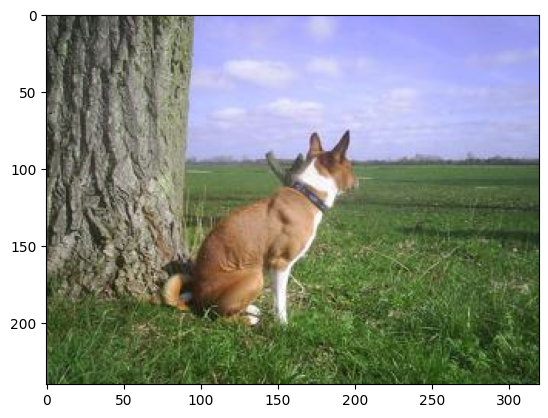

Label: 0.0, Category: cat


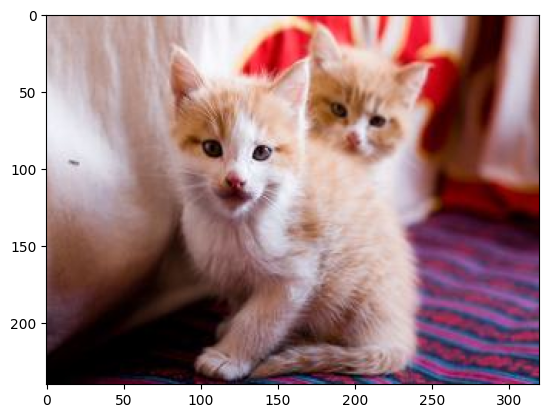

Label: 0.0, Category: cat


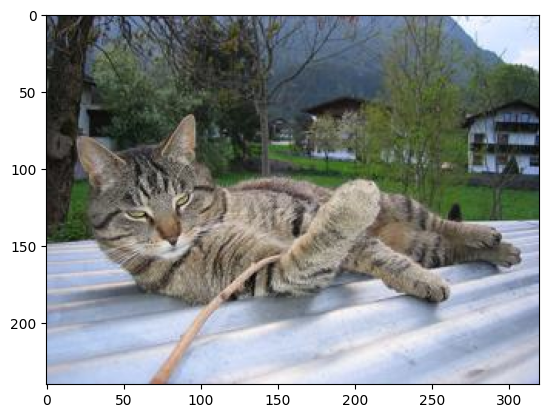

Label: 0.0, Category: cat


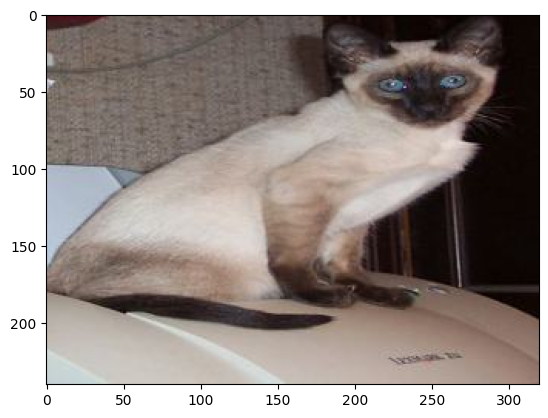

In [117]:
# implement your solution BELOW
import matplotlib.pyplot as plt
import numpy as np
import torch

categories = ['cat', 'dog']

def imshow(img):
    img = img * torch.tensor(MOBILENET_STDS).view(3, 1, 1)
    img = img + torch.tensor(MOBILENET_MEANS).view(3, 1, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

dataiter_train = iter(dataloader_train)
images_train, labels_train = next(dataiter_train)

for i in range(2):
    print(f'Label: {labels_train[i].item()}, Category: {categories[int(labels_train[i].item())]}')
    imshow(images_train[i])

dataiter_val = iter(dataloader_val)
images_val, labels_val = next(dataiter_val)

for i in range(2):
    print(f'Label: {labels_val[i].item()}, Category: {categories[int(labels_val[i].item())]}')
    imshow(images_val[i])


### **F**: A háló betanítása bináris klasszifikációs feladatra - 7 pont

**Tanítsd be az** `ft_model` **neuronhálót** a tanítóhalmazon a `dataloader_train` iterátor segítségével és alkalmazd a `dataloader_val` iterátort a validációhoz!

Alkalmazd a bináris klasszifikációkor szokásosan használt **binary cross-entropy költséget**! **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonon a jelmagyarázat meglétére és a görbék könnyű elkülöníthetőségére figyelj ezúttal is! **Számold ki a bináris _accuracy_ (pontosság) metrikát minden epoch-ban a tanító- és a validációs halmazon** és jelöld ezek alakulását is a grafikonon!

A tanítást az **early stopping** technika állítsa le! Amennyiben adott számú epoch-on keresztül (`patience`) nem javul a validációs költség, érjen véget a betanítás és **állítsuk vissza az `ft_model` súlyait abból az epoch-ból, amikor a legjobb volt a validációs költség!** Mindez automatikusan történjen!

A betanítást követően **számold ki a bináris _accuracy_ metrikát a teszthalmaz elemein is** és add értékül a kapott számot a `test_acc` változónak! Az _accuracy_ metrika a helyesen klasszifikált mintaelemek arányát adja meg. Például, ha 150 mintaelem kategóriájának becslésekor 75 esetben találtuk el a helyes kategóriát, az _accuracy_ értéke 0.5 lesz.

_**Megjegyzés:** Megfelelően választott tanulási rátával 1-2 perc (CPU) tanítás elegendő a tesztelő által elvárt `test_acc` eléréséhez (akár 2-3 epoch)._

Epoch 1/3, Train Loss: 0.6278, Train Acc: 0.6736, Val Loss: 0.5750, Val Acc: 0.7333
Epoch 2/3, Train Loss: 0.4891, Train Acc: 0.8512, Val Loss: 0.4673, Val Acc: 0.8333
Epoch 3/3, Train Loss: 0.4017, Train Acc: 0.8926, Val Loss: 0.3860, Val Acc: 0.8917


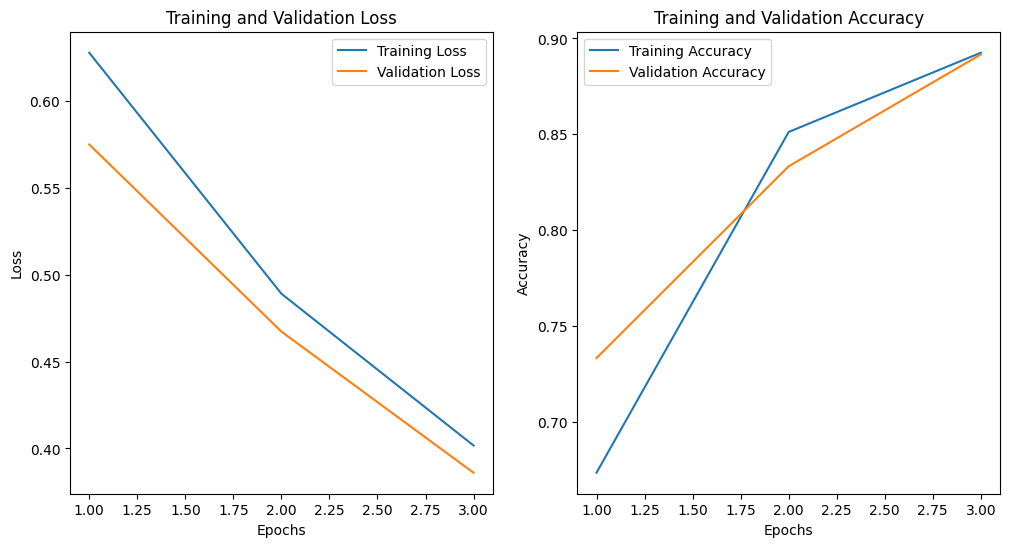

Test accuracy is: 86.17886304855347 %
Tester: Model training (Task F) OK


In [118]:
# implement your solution BELOW
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ft_model.to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
best_val_loss = float('inf')
best_model_wts = None
no_improvement_count = 0

num_epochs = 3  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(y_true, y_pred):
    y_pred = torch.round(y_pred)
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0
    
    for inputs, labels in dataloader_train:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += calculate_accuracy(labels, outputs) * inputs.size(0)
        total_train += inputs.size(0)
    
    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader_val:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(labels, outputs) * inputs.size(0)
            total_val += inputs.size(0)
    
    val_loss = running_loss / total_val
    val_acc = running_corrects / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict().copy()
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping")
            break

if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

model.eval()
running_corrects = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        
        outputs = model(inputs)
        running_corrects += calculate_accuracy(labels, outputs) * inputs.size(0)
        total_test += inputs.size(0)

test_acc = running_corrects / total_test
test_acc = test_acc.item()
print("Test accuracy is:", test_acc * 100, "%")


# implement your solution ABOVE

tester.test('F', test_acc)

In [93]:
### **G**: Néhány predikció kirajzolása - 3 pont

Mintavételezz pár képet a **teszt iterátorból**, becsülj rájuk címkét a betanított modellel, majd rajzold ki a képeket és írd ki föléjük a becsült és a helyes címkét! Hasonlóan az E) részfeladathoz, itt is figyelned kell a képek helyes megjelenítésére!

SyntaxError: unmatched ')' (1275832998.py, line 3)

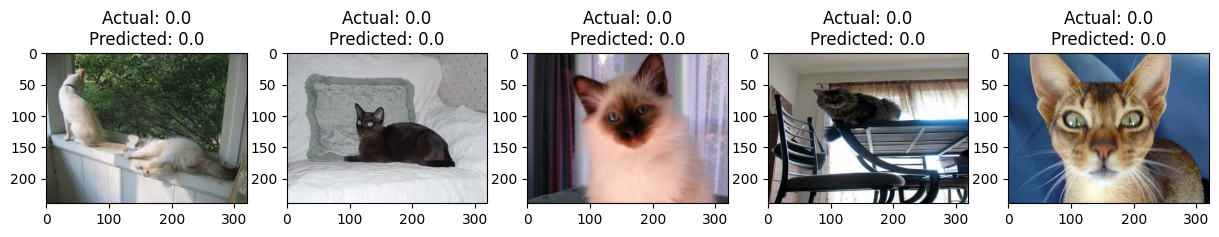

In [119]:
# implement your solution BELOW

def unnormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array(MOBILENET_STDS) + np.array(MOBILENET_MEANS)
    img = np.clip(img, 0, 1)
    return img

num_samples = 5
model.eval()
sample_images, sample_labels, sample_preds = [], [], []

with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        outputs = model(inputs)
        preds = torch.round(outputs).cpu()

        sample_images.extend(inputs.cpu())
        sample_labels.extend(labels.cpu())
        sample_preds.extend(preds)
        
        if len(sample_images) >= num_samples:
            sample_images = sample_images[:num_samples]
            sample_labels = sample_labels[:num_samples]
            sample_preds = sample_preds[:num_samples]
            break

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    ax = axes[i]
    img = unnormalize(sample_images[i])
    ax.imshow(img)
    ax.set_title(f'Actual: {sample_labels[i].item()}\nPredicted: {sample_preds[i].item()}')

plt.show()


### **H**: Hőtérkép kirajzolása - 5 pont

Válassz egy képet a tesztiterátorból, majd értékeld ki a betanított neuronhálót rajta! Válaszd ki a neuronháló egyik közbenső konvolúciós rétegét (pl. `mobile_net.features[7].conv[3]`), majd keresd meg ezen réteg kimeneti hőtérképei közül azt a csatornát, amelyiknek az átlagos pixelértéke maximális! Rajzold ki ezt a hőtérképet és az eredeti input képet együtt!

In [120]:
# implement your solution BELOW

image, label = next(iter(dataloader_test))

model.eval()
with torch.no_grad():
    output = model(image)

intermediate_layer = model.mobilenet.features[7].conv[3]

output_intermediate = intermediate_layer(image)
mean_channel_values = output_intermediate.mean(dim=(2, 3))  
max_mean_channel = mean_channel_values.argmax(dim=1).item()  

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image[0], (1, 2, 0)))
plt.title('Eredeti Kép')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_intermediate[0, max_mean_channel].cpu(), cmap='hot')
plt.title('Maximális Átlagos Pixelértékű Hőtérkép')
plt.axis('off')

plt.show()







RuntimeError: running_mean should contain 3 elements not 64